# Text classification with (mostly) linear classifiers

In [1]:
import operator, os, random, time, glob, string, nltk, requests, gzip, shutil, warnings, urllib.request, tarfile
from functools import reduce
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve, f1_score, auc, roc_curve, roc_auc_score, average_precision_score
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics.classification import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
import scikitplot as skplt

In [2]:
def download_enron():
    if os.path.isdir('enron1'):
        print('Enron dataset already exists!')
        return
    print("Downloading Enron dataset...")
    urllib.request.urlretrieve('http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/preprocessed/enron1.tar.gz', 'enron1.tar.gz')
    print("Extracting Enron dataset...")
    tar = tarfile.open('enron1.tar.gz', "r:gz")
    tar.extractall()
    tar.close()
    print("Enron dataset extracted.")

In [3]:
from os import listdir

def read_enron():
    spam_files = glob.glob('enron1/spam/*.txt')
    ham_files = glob.glob('enron1/ham/*.txt')
    
    #spam_files = glob.glob('enron1/spam/*.txt')+glob.glob('enron2/spam/*.txt')+glob.glob('enron3/spam/*.txt')
    #ham_files = glob.glob('enron1/ham/*.txt')+glob.glob('enron2/ham/*.txt')+glob.glob('enron3/ham/*.txt')

    emails = []
    y = []
    for spam_file in spam_files:
        f = open(spam_file, 'r', errors='ignore')
        emails.append(f.read())
        y.append(1)
        f.close()

    for ham_file in ham_files:
        f = open(ham_file, 'r', errors='ignore')
        emails.append(f.read())
        y.append(0)
        f.close()
        
    return emails, y

In [4]:
stemmer = nltk.stem.PorterStemmer()
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()

In [5]:
def clean_text(docs, lower=True, punctuation=False, isalpha=False, stopwords=True, lemmatize=True, stem=True):
    processed_docs = []
    for doc_id, text in enumerate(docs):
        wordlist = nltk.word_tokenize(text)
        # lowercase
        if lower: wordlist = [w.lower() for w in wordlist]
        # remove punctuation
        if punctuation:
            table = str.maketrans('', '', string.punctuation)
            wordlist = [w.translate(table) for w in wordlist]
        # remove tokens that are not alphabetic
        if isalpha: wordlist = [w for w in wordlist if w.isalpha()]
        # filter out stop words
        if stopwords: wordlist = [w for w in wordlist if not w in stop_words]
        # lemmatize tokens
        if lemmatize: wordlist = [wordnet_lemmatizer.lemmatize(w) for w in wordlist]
        # make stemming
        if stem: wordlist = [stemmer.stem(w) for w in wordlist]

        doc = ' '.join(w for w in wordlist)
        processed_docs.append(doc)       

    return processed_docs

# Read data

First download Enron dataset

In [6]:
download_enron()

Extracting Enron dataset...
Enron dataset extracted.


Run the function read_enron() to load the data from the disk. Print an email. Compute how many spam and ham emails are contained in the dataset and the spam ratio.

In [7]:
emails, y = read_enron()
print(emails[2],'\n')
print("Total number of emails:", len(y))
print("Number of ham emails:", y.count(0))
print("Number of spam emails:", y.count(1))
print('Spam ratio:', round(y.count(1)/(y.count(0)+y.count(1)),2))

Subject: get that new car 8434
people nowthe weather or climate in any particular environment can change and affect what people eat and how much of it they are able to eat . 

Total number of emails: 5172
Number of ham emails: 3672
Number of spam emails: 1500
Spam ratio: 0.29


# Preprocess the emails

Use the function clean_text() to preprocess the emails of the dataset.

In [8]:
processed_emails = clean_text(emails, lower=True, punctuation=False, isalpha=True, 
                              stopwords=True, lemmatize=False, stem=False)

In [9]:
processed_emails[2]

'subject new car people nowthe weather climate particular environment change affect people eat able eat'

# REPRESENTATION 1 - Bag Of Words

## 1.1 TERM COUNT, ngram_range=(1,1)

### Feature extraction - Data representation

In [10]:
X_train, X_test, y_train, y_test = train_test_split(processed_emails, y, test_size=0.3, random_state=0, stratify=y)

In [11]:
vectorizer = CountVectorizer(ngram_range=(1,1))

In [12]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [13]:
print(X_train.shape)
print(X_test.shape)

(3620, 36738)
(1552, 36738)


### Hyperparameter tuning - Fitting

We choose to experiment with five algorithms: 'Logistic Regression', 'SGD', 'Naive Bayes', 'Nearest Neighbors' and 'SVM'. Also a baseline 'Dummy' classifier predicting always the majority class (ham) is used for comparison.
With 10-fold stratified cross-validation using sklearn's object GridSearchCV or our defined functions we find the best parameters (like  regularization weight λ, penalty parameter C of the error term, etc) for all used classifiers.
Although accuracy would appear to be the obvious choice for evaluating the quality of a classifier, it can be a crude measure sometimes, and is not suited for some datasets including the Enron one. For example, if a classifier were to guess that all of the samples in the dataset were ham, it would have an accuracy of 71.01%.
Therefore, different metrics are needed to evaluate the classifiers to gauge performance. The one selected for use in this assignment is a combined measurement of precision and recall, the F1 score. Is it the harmonic mean of precision and recall. Mathematically, the F1 score is defined as:
$$ {F1} =  \frac{2*Precision*Recall}{Precision+Recall} $$

In [14]:
#Estimators
dummy = DummyClassifier(strategy='most_frequent', random_state=13)
logregr = LogisticRegression(solver='liblinear', random_state=13, n_jobs=-1)
sgd = SGDClassifier(max_iter=1000, tol=1e-3, random_state=13, n_jobs=-1)
nb = MultinomialNB()
knn = KNeighborsClassifier()
svm = LinearSVC(max_iter=100000, random_state=13)

#Cross validation strategy
skf = StratifiedKFold(n_splits=10, random_state=1)
#Scores could also be ['precision', 'recall', 'f1']
scores = ['f1']

In [15]:
def logistic_CV(X_train, y_train, C_hyperparam):
    print("{:<8}{:<6}".format('C', 'f1-score'))
    for c in C_hyperparam:
        kfold_scores = []
        for train_index, test_index in skf.split(X_train, y_train):

            emails_train, emails_test = X_train[train_index], X_train[test_index]
            labels_train, labels_test = np.asarray(y_train)[train_index], np.asarray(y_train)[test_index]
            logregr = LogisticRegression(C=c, solver='liblinear',  max_iter=100, random_state=13).fit(emails_train, labels_train)
            predictions_logregr = logregr.predict(emails_test)

            acc = f1_score(labels_test, predictions_logregr)
            kfold_scores.append(acc)
        mean_score = round(np.mean(kfold_scores), 4)
        print("{:<8}{:<6}".format(c, mean_score))

In [16]:
C_hyperparam=[0.01, 0.1, 1, 10, 100, 1000]
logistic_CV(X_train, y_train, C_hyperparam)

C       f1-score
0.01    0.9623
0.1     0.9644
1       0.9624
10      0.9604
100     0.9523
1000    0.9452


In [17]:
def SGD_CV(X_train, y_train, C_hyperparam):
    print("{:<8}{:<6}".format('C', 'f1-score'))
    for c in C_hyperparam:
        kfold_scores = []
        for train_index, test_index in skf.split(X_train, y_train):

            emails_train, emails_test = X_train[train_index], X_train[test_index]
            labels_train, labels_test = np.asarray(y_train)[train_index], np.asarray(y_train)[test_index]
            sgd = SGDClassifier(alpha=c, max_iter=1000, tol=1e-3, random_state=13).fit(emails_train, labels_train)
            predictions_sgd = sgd.predict(emails_test)

            acc = f1_score(labels_test, predictions_sgd)
            kfold_scores.append(acc)
        mean_score = round(np.mean(kfold_scores), 4)
        print("{:<8}{:<6}".format(c, mean_score))

In [18]:
C_hyperparam=[0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
SGD_CV(X_train, y_train, C_hyperparam)

C       f1-score
1e-06   0.9475
1e-05   0.9458
0.0001  0.9522
0.001   0.9649
0.01    0.9639
0.1     0.9626


In [19]:
def knn_cv(X_train, y_train, C_hyperparam):
    print("{:<8}{:<6}".format('C', 'f1-score'))
    for c in C_hyperparam:
        kfold_scores = []
        for train_index, test_index in skf.split(X_train, y_train):

            emails_train, emails_test = X_train[train_index], X_train[test_index]
            labels_train, labels_test = np.asarray(y_train)[train_index], np.asarray(y_train)[test_index]
            knn = KNeighborsClassifier(n_neighbors=c, weights='distance').fit(emails_train, labels_train)
            predictions_knn = knn.predict(emails_test)

            acc = f1_score(labels_test, predictions_knn)
            kfold_scores.append(acc)
        mean_score = round(np.mean(kfold_scores), 4)
        print("{:<8}{:<6}".format(c, mean_score))

In [20]:
C_hyperparam = np.arange(1, 25)
knn_cv(X_train, y_train, C_hyperparam)

C       f1-score
1       0.8219
2       0.8243
3       0.7978
4       0.7928
5       0.7601
6       0.7628
7       0.7432
8       0.7461
9       0.7315
10      0.7323
11      0.7205
12      0.7205
13      0.7115
14      0.7122
15      0.7061
16      0.7075
17      0.7019
18      0.7032
19      0.6975
20      0.6977
21      0.692 
22      0.6955
23      0.691 
24      0.6926


In [21]:
def SVM_CV(X_train, y_train, C_hyperparam):
    print("{:<8}{:<6}".format('C', 'f1-score'))
    for c in C_hyperparam:
        kfold_scores = []
        for train_index, test_index in skf.split(X_train, y_train):

            emails_train, emails_test = X_train[train_index], X_train[test_index]
            labels_train, labels_test = np.asarray(y_train)[train_index], np.asarray(y_train)[test_index]
            #svm = SVC(C=c, gamma='auto', kernel='linear').fit(emails_train, labels_train)
            svm = LinearSVC(C=c, class_weight=None, max_iter=10000).fit(emails_train, labels_train)
            predictions_svm = svm.predict(emails_test)

            acc = f1_score(labels_test, predictions_svm)
            kfold_scores.append(acc)
        mean_score = round(np.mean(kfold_scores), 4)
        print("{:<8}{:<6}".format(c, mean_score))

In [22]:
C_hyperparam = [0.0001, .001, .01, .1, 1]
SVM_CV(X_train, y_train, C_hyperparam)

C       f1-score
0.0001  0.6679
0.001   0.9625
0.01    0.9626
0.1     0.9589
1       0.9403


**Parameter tuning**, **classifier fitting** and **classification scoring** for the test set are implemented in function hyper_tuning(). We report f1-score for the positive class (spam) and supplementary accuracy score.

In [23]:
def hyper_tuning(train, test, scores, estimator, parameters, cv):
    print("# Estimator:",estimator)
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)        
        clf = GridSearchCV(estimator, parameters, cv=cv, scoring='%s' % score)
        clf.fit(train, y_train)
        print("Best parameters set found on development set:")
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print()
        print("Detailed classification report:")
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        y_pred = clf.predict(test)
        print(classification_report(y_test, y_pred, digits=4))
        print('Accuracy: {0:0.4f}   f1-score(for the positive class): {1:0.4f}'.format(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)))
    return clf

In [24]:
params = [{'C': [0.001, 0.01, 0.1, 1, 1000, 10000]}]
logregr = hyper_tuning(X_train, X_test, scores, logregr, params, skf)

# Estimator: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=13, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
# Tuning hyper-parameters for f1


c:\program files\python36\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Best parameters set found on development set:
{'C': 0.1}

Grid scores on development set:
0.684 (+/-0.072) for {'C': 0.001}
0.962 (+/-0.037) for {'C': 0.01}
0.964 (+/-0.032) for {'C': 0.1}
0.962 (+/-0.026) for {'C': 1}
0.945 (+/-0.023) for {'C': 1000}
0.946 (+/-0.027) for {'C': 10000}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           0     0.9935    0.9782    0.9858      1102
           1     0.9486    0.9844    0.9662       450

   micro avg     0.9800    0.9800    0.9800      1552
   macro avg     0.9711    0.9813    0.9760      1552
weighted avg     0.9805    0.9800    0.9801      1552

Accuracy: 0.9800   f1-score(for the positive class): 0.9662


In [25]:
params = [{'alpha': [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10]}]
sgd = hyper_tuning(X_train, X_test, scores, sgd, params, skf)

# Estimator: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=13, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)
# Tuning hyper-parameters for f1
Best parameters set found on development set:
{'alpha': 0.001}

Grid scores on development set:
0.952 (+/-0.025) for {'alpha': 1e-07}
0.948 (+/-0.035) for {'alpha': 1e-06}
0.946 (+/-0.031) for {'alpha': 1e-05}
0.952 (+/-0.043) for {'alpha': 0.0001}
0.965 (+/-0.034) for {'alpha': 0.001}
0.964 (+/-0.029) for {'alpha': 0.01}
0.963 (+/-0.037) for {'alpha': 0.1}
0.645 (+/-0.075) for {'alpha': 1.0}
0.147 (+/-0.104) for {'alpha': 10}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evalua

In [26]:
params = {'alpha': [1.0, 0.1, 0.01],  'fit_prior':[True, False]}
nb = hyper_tuning(X_train, X_test, scores, nb, params, skf)

# Estimator: MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
# Tuning hyper-parameters for f1
Best parameters set found on development set:
{'alpha': 0.01, 'fit_prior': False}

Grid scores on development set:
0.959 (+/-0.033) for {'alpha': 1.0, 'fit_prior': True}
0.962 (+/-0.034) for {'alpha': 1.0, 'fit_prior': False}
0.962 (+/-0.035) for {'alpha': 0.1, 'fit_prior': True}
0.964 (+/-0.033) for {'alpha': 0.1, 'fit_prior': False}
0.964 (+/-0.029) for {'alpha': 0.01, 'fit_prior': True}
0.965 (+/-0.028) for {'alpha': 0.01, 'fit_prior': False}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           0     0.9890    0.9809    0.9850      1102
           1     0.9542    0.9733    0.9637       450

   micro avg     0.9787    0.9787    0.9787      1552
   macro avg     0.9716    0.9771    0.9743      1552
weighted avg     0.9789    0.9787    0

In [27]:
params = [{'n_neighbors': np.arange(1, 4), 'leaf_size': [20, 30], 'weights': ['distance', 'uniform']}]
knn = hyper_tuning(X_train, X_test, scores, knn, params, skf)

# Estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')
# Tuning hyper-parameters for f1
Best parameters set found on development set:
{'leaf_size': 20, 'n_neighbors': 2, 'weights': 'distance'}

Grid scores on development set:
0.822 (+/-0.049) for {'leaf_size': 20, 'n_neighbors': 1, 'weights': 'distance'}
0.822 (+/-0.049) for {'leaf_size': 20, 'n_neighbors': 1, 'weights': 'uniform'}
0.824 (+/-0.046) for {'leaf_size': 20, 'n_neighbors': 2, 'weights': 'distance'}
0.813 (+/-0.051) for {'leaf_size': 20, 'n_neighbors': 2, 'weights': 'uniform'}
0.798 (+/-0.048) for {'leaf_size': 20, 'n_neighbors': 3, 'weights': 'distance'}
0.789 (+/-0.045) for {'leaf_size': 20, 'n_neighbors': 3, 'weights': 'uniform'}
0.822 (+/-0.049) for {'leaf_size': 30, 'n_neighbors': 1, 'weights': 'distance'}
0.822 (+/-0.049) for {'leaf_size': 30, 'n_neighbors': 1, 'weights': 'uniform'}
0.824 (+/-0.0

In [28]:
params = [{'C': [0.0001, 0.001, .01, 1, 10, 100, 1000]}]
svm = hyper_tuning(X_train, X_test, scores, svm, params, skf)

# Estimator: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=100000,
     multi_class='ovr', penalty='l2', random_state=13, tol=0.0001,
     verbose=0)
# Tuning hyper-parameters for f1
Best parameters set found on development set:
{'C': 0.01}

Grid scores on development set:
0.668 (+/-0.075) for {'C': 0.0001}
0.962 (+/-0.035) for {'C': 0.001}
0.963 (+/-0.034) for {'C': 0.01}
0.940 (+/-0.030) for {'C': 1}
0.930 (+/-0.037) for {'C': 10}
0.928 (+/-0.036) for {'C': 100}
0.928 (+/-0.036) for {'C': 1000}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           0     0.9926    0.9764    0.9844      1102
           1     0.9444    0.9822    0.9630       450

   micro avg     0.9781    0.9781    0.9781      1552
   macro avg     0.9685    0.9793    0.9737      1552
weighted avg 

#### Fitted estimators

In [29]:
dummy.fit(X_train, y_train)
names = ['Dummy', 'Logistic Regression', 'SGD', 'Naive Bayes', 'Nearest Neighbors', 'SVM']
classifiers = [dummy, logregr, sgd, nb, knn, svm]

### Evaluation

#### Learning curves

In [30]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("F1 score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [31]:
def plot_learning_curves():
    fig = plt.figure(figsize=(15,10))
    i=1

    for name, clf in zip(names, classifiers):
        plt.subplot(2, 3, i)
        plot_learning_curve(clf, name, X_train, y_train, ylim=(0.7, 1.01), cv=3, n_jobs=-1)
        i +=1 

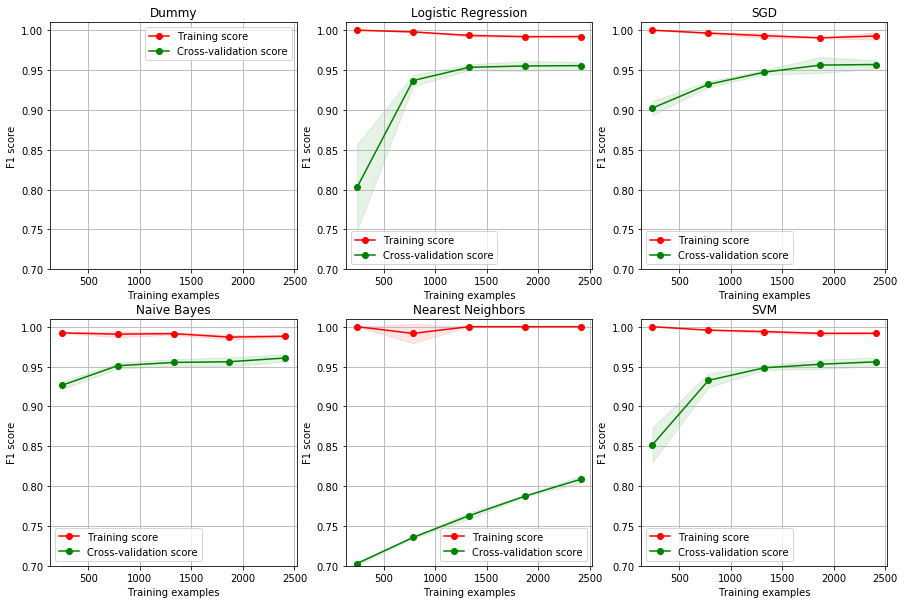

In [32]:
plot_learning_curves()

#### Precision-Recall curves

In [33]:
def plot_precision_recall():
    plt.figure(figsize=(10,7))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curves')
    for name, clf in zip(names, classifiers):
        try:
            proba = clf.predict_proba(X_test)[:, 1]
        except:
            proba = clf.decision_function(X_test)
        precision, recall, thresholds  = precision_recall_curve(y_test, proba)
        plt.plot(recall, precision,
                 label='{0:s} (AUC={1:0.4f})'.format(name,average_precision_score(y_test, proba)))
        #plt.plot(recall, precision,
        #         label='{0:s} (ROC={1:0.4f})'.format(name,roc_auc_score(y_test, proba)))
        plt.legend()

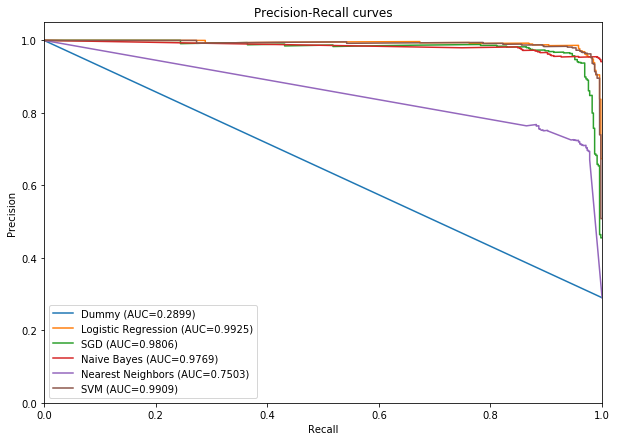

In [34]:
plot_precision_recall()

#### Confusion matrix

In [35]:
def plot_confusion_matrix(f1,
                          cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          i=1):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}; f1-score={:0.4f}'.format(accuracy, misclass, f1))

In [36]:
def plot_confusion():
    probs=[]
    i=1
    plt.figure(figsize=(15, 7))

    for name, clf in zip(names, classifiers):
        plt.subplot(2, 3, i)
        y_pred = clf.predict(X_test)
        cnf_matrix_tra = confusion_matrix(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        plot_confusion_matrix(f1, cnf_matrix_tra , target_names=['ham', 'spam'], title='Confusion matrix for '+name+' classifier', normalize=False)
        i+=1

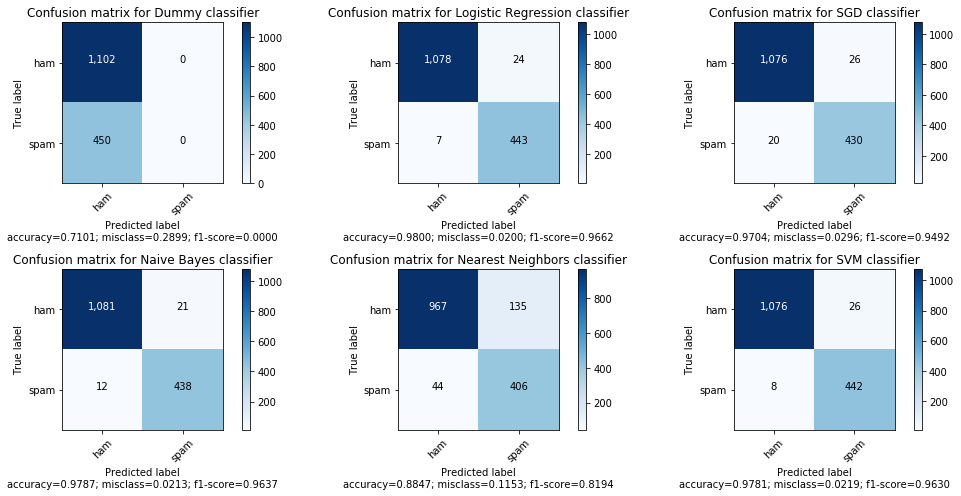

In [37]:
plot_confusion()

## 1.2 TFIDF, ngram_range=(1,1)

### Feature extraction - Data representation

In [38]:
X_train, X_test, y_train, y_test = train_test_split(processed_emails, y, test_size=0.3, random_state=0, stratify=y)

In [39]:
vectorizer = TfidfVectorizer(ngram_range=(1,1),  use_idf=True)

In [40]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

### Hyperparameter tuning - Fitting

In [41]:
#Estimators
dummy = DummyClassifier(strategy='most_frequent', random_state=13)
logregr = LogisticRegression(solver='liblinear', random_state=13, n_jobs=-1)
sgd = SGDClassifier(max_iter=1000, tol=1e-3, random_state=13, n_jobs=-1)
nb = MultinomialNB()
knn = KNeighborsClassifier()
svm = LinearSVC(max_iter=100000, random_state=13)

#Cross validation strategy
skf = StratifiedKFold(n_splits=10, random_state=1)
#Scores could also be ['precision', 'recall', 'f1']
scores = ['f1']

In [42]:
params = [{'C': [0.001, 0.01, 0.1, 1, 1000, 10000]}]
logregr = hyper_tuning(X_train, X_test, scores, logregr, params, skf)

# Estimator: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=13, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
# Tuning hyper-parameters for f1


c:\program files\python36\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Best parameters set found on development set:
{'C': 1000}

Grid scores on development set:
0.000 (+/-0.000) for {'C': 0.001}
0.000 (+/-0.000) for {'C': 0.01}
0.506 (+/-0.151) for {'C': 0.1}
0.977 (+/-0.033) for {'C': 1}
0.981 (+/-0.026) for {'C': 1000}
0.981 (+/-0.029) for {'C': 10000}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           0     0.9964    0.9909    0.9936      1102
           1     0.9781    0.9911    0.9845       450

   micro avg     0.9910    0.9910    0.9910      1552
   macro avg     0.9872    0.9910    0.9891      1552
weighted avg     0.9911    0.9910    0.9910      1552

Accuracy: 0.9910   f1-score(for the positive class): 0.9845


In [43]:
params = [{'alpha': [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10]}]
sgd = hyper_tuning(X_train, X_test, scores, sgd, params, skf)

# Estimator: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=13, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)
# Tuning hyper-parameters for f1
Best parameters set found on development set:
{'alpha': 0.0001}

Grid scores on development set:
0.967 (+/-0.025) for {'alpha': 1e-07}
0.963 (+/-0.023) for {'alpha': 1e-06}
0.978 (+/-0.027) for {'alpha': 1e-05}
0.980 (+/-0.031) for {'alpha': 0.0001}
0.975 (+/-0.034) for {'alpha': 0.001}
0.052 (+/-0.051) for {'alpha': 0.01}
0.000 (+/-0.000) for {'alpha': 0.1}
0.000 (+/-0.000) for {'alpha': 1.0}
0.000 (+/-0.000) for {'alpha': 10}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evalu

In [44]:
params = {'alpha': [1.0, 0.1, 0.01],  'fit_prior':[True, False]}
nb = hyper_tuning(X_train, X_test, scores, nb, params, skf)

# Estimator: MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
# Tuning hyper-parameters for f1
Best parameters set found on development set:
{'alpha': 0.1, 'fit_prior': False}

Grid scores on development set:
0.839 (+/-0.062) for {'alpha': 1.0, 'fit_prior': True}
0.955 (+/-0.026) for {'alpha': 1.0, 'fit_prior': False}
0.965 (+/-0.023) for {'alpha': 0.1, 'fit_prior': True}
0.966 (+/-0.029) for {'alpha': 0.1, 'fit_prior': False}
0.964 (+/-0.018) for {'alpha': 0.01, 'fit_prior': True}
0.963 (+/-0.030) for {'alpha': 0.01, 'fit_prior': False}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           0     0.9872    0.9837    0.9855      1102
           1     0.9604    0.9689    0.9646       450

   micro avg     0.9794    0.9794    0.9794      1552
   macro avg     0.9738    0.9763    0.9750      1552
weighted avg     0.9795    0.9794    0.

In [45]:
params = [{'n_neighbors': np.arange(1, 4), 'leaf_size': [20, 30], 'weights': ['distance', 'uniform']}]
knn = hyper_tuning(X_train, X_test, scores, knn, params, skf)

# Estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')
# Tuning hyper-parameters for f1
Best parameters set found on development set:
{'leaf_size': 20, 'n_neighbors': 3, 'weights': 'distance'}

Grid scores on development set:
0.930 (+/-0.025) for {'leaf_size': 20, 'n_neighbors': 1, 'weights': 'distance'}
0.930 (+/-0.025) for {'leaf_size': 20, 'n_neighbors': 1, 'weights': 'uniform'}
0.930 (+/-0.025) for {'leaf_size': 20, 'n_neighbors': 2, 'weights': 'distance'}
0.895 (+/-0.044) for {'leaf_size': 20, 'n_neighbors': 2, 'weights': 'uniform'}
0.938 (+/-0.036) for {'leaf_size': 20, 'n_neighbors': 3, 'weights': 'distance'}
0.937 (+/-0.037) for {'leaf_size': 20, 'n_neighbors': 3, 'weights': 'uniform'}
0.930 (+/-0.025) for {'leaf_size': 30, 'n_neighbors': 1, 'weights': 'distance'}
0.930 (+/-0.025) for {'leaf_size': 30, 'n_neighbors': 1, 'weights': 'uniform'}
0.930 (+/-0.0

In [46]:
params = [{'C': [0.0001, 0.001, .01, 1, 10, 100, 1000]}]
svm = hyper_tuning(X_train, X_test, scores, svm, params, skf)

# Estimator: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=100000,
     multi_class='ovr', penalty='l2', random_state=13, tol=0.0001,
     verbose=0)
# Tuning hyper-parameters for f1
Best parameters set found on development set:
{'C': 1}

Grid scores on development set:
0.000 (+/-0.000) for {'C': 0.0001}
0.000 (+/-0.000) for {'C': 0.001}
0.422 (+/-0.137) for {'C': 0.01}
0.982 (+/-0.026) for {'C': 1}
0.982 (+/-0.026) for {'C': 10}
0.981 (+/-0.028) for {'C': 100}
0.981 (+/-0.028) for {'C': 1000}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           0     0.9963    0.9900    0.9932      1102
           1     0.9759    0.9911    0.9835       450

   micro avg     0.9903    0.9903    0.9903      1552
   macro avg     0.9861    0.9906    0.9883      1552
weighted avg    

In [47]:
dummy.fit(X_train, y_train)
names = ['Dummy', 'Logistic Regression', 'SGD', 'Naive Bayes', 'Nearest Neighbors', 'SVM']
classifiers = [dummy, logregr, sgd, nb, knn, svm]

### Evaluation

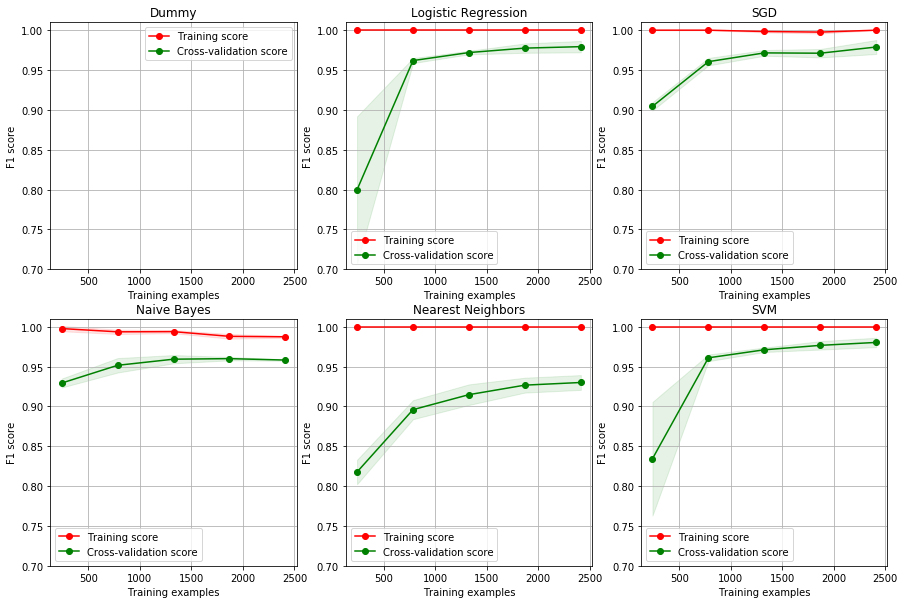

In [48]:
plot_learning_curves()

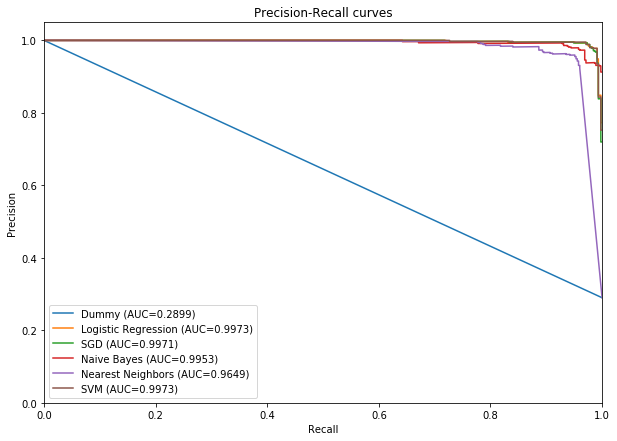

In [49]:
plot_precision_recall()

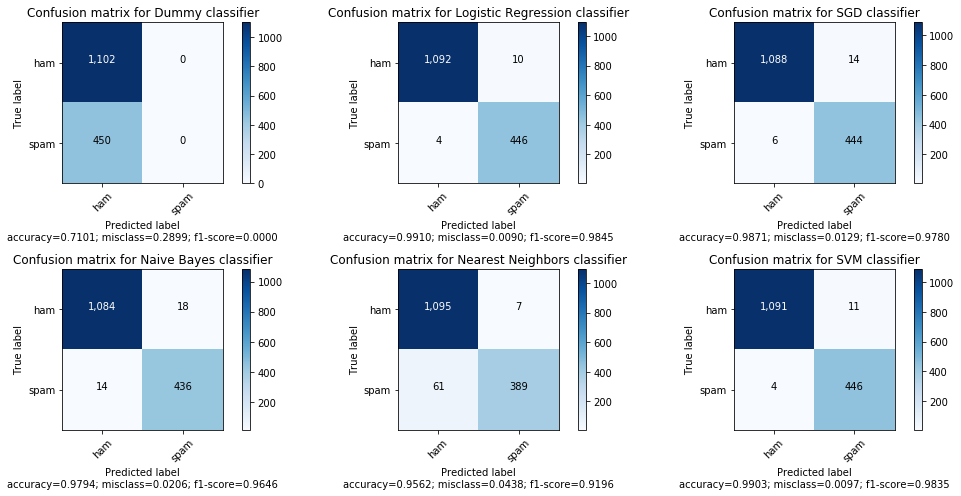

In [50]:
plot_confusion()

## 1.3 TFIDF, ngram_range=(1,3)

### Feature extraction - Data representation

In [51]:
X_train, X_test, y_train, y_test = train_test_split(processed_emails, y, test_size=0.3, random_state=0, stratify=y)

In [52]:
vectorizer = TfidfVectorizer(ngram_range=(1,3),  use_idf=True)

In [53]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [54]:
X_train.shape

(3620, 406099)

### Hyperparameter tuning - Fitting

In [55]:
#Estimators
dummy = DummyClassifier(strategy='most_frequent', random_state=13)
logregr = LogisticRegression(solver='liblinear', random_state=13, n_jobs=-1)
sgd = SGDClassifier(max_iter=1000, tol=1e-3, random_state=13, n_jobs=-1)
nb = MultinomialNB()
knn = KNeighborsClassifier(n_jobs=-1)
svm = LinearSVC(max_iter=100000, random_state=13)

#Cross validation strategy
skf = StratifiedKFold(n_splits=10, random_state=1)
#Scores could also be ['precision', 'recall', 'f1']
scores = ['f1']

In [56]:
params = [{'C': [0.001, 0.01, 0.1, 1, 1000, 10000]}]
logregr = hyper_tuning(X_train, X_test, scores, logregr, params, skf)

# Estimator: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=13, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
# Tuning hyper-parameters for f1


c:\program files\python36\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Best parameters set found on development set:
{'C': 1000}

Grid scores on development set:
0.000 (+/-0.000) for {'C': 0.001}
0.000 (+/-0.000) for {'C': 0.01}
0.046 (+/-0.025) for {'C': 0.1}
0.870 (+/-0.058) for {'C': 1}
0.980 (+/-0.026) for {'C': 1000}
0.980 (+/-0.026) for {'C': 10000}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           0     0.9946    0.9946    0.9946      1102
           1     0.9867    0.9867    0.9867       450

   micro avg     0.9923    0.9923    0.9923      1552
   macro avg     0.9906    0.9906    0.9906      1552
weighted avg     0.9923    0.9923    0.9923      1552

Accuracy: 0.9923   f1-score(for the positive class): 0.9867


In [57]:
params = [{'alpha': [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10]}]
sgd = hyper_tuning(X_train, X_test, scores, sgd, params, skf)

# Estimator: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=13, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)
# Tuning hyper-parameters for f1
Best parameters set found on development set:
{'alpha': 0.0001}

Grid scores on development set:
0.968 (+/-0.017) for {'alpha': 1e-07}
0.976 (+/-0.020) for {'alpha': 1e-06}
0.977 (+/-0.024) for {'alpha': 1e-05}
0.981 (+/-0.024) for {'alpha': 0.0001}
0.913 (+/-0.043) for {'alpha': 0.001}
0.000 (+/-0.000) for {'alpha': 0.01}
0.000 (+/-0.000) for {'alpha': 0.1}
0.000 (+/-0.000) for {'alpha': 1.0}
0.000 (+/-0.000) for {'alpha': 10}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evalu

In [58]:
params = {'alpha': [1.0, 0.1, 0.01],  'fit_prior':[True, False]}
nb = hyper_tuning(X_train, X_test, scores, nb, params, skf)

# Estimator: MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
# Tuning hyper-parameters for f1
Best parameters set found on development set:
{'alpha': 1.0, 'fit_prior': False}

Grid scores on development set:
0.647 (+/-0.093) for {'alpha': 1.0, 'fit_prior': True}
0.966 (+/-0.024) for {'alpha': 1.0, 'fit_prior': False}
0.959 (+/-0.030) for {'alpha': 0.1, 'fit_prior': True}
0.947 (+/-0.037) for {'alpha': 0.1, 'fit_prior': False}
0.922 (+/-0.033) for {'alpha': 0.01, 'fit_prior': True}
0.903 (+/-0.032) for {'alpha': 0.01, 'fit_prior': False}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           0     0.9491    0.9982    0.9730      1102
           1     0.9949    0.8689    0.9276       450

   micro avg     0.9607    0.9607    0.9607      1552
   macro avg     0.9720    0.9335    0.9503      1552
weighted avg     0.9624    0.9607    0.

In [59]:
params = [{'n_neighbors': np.arange(1, 5), 'leaf_size': [20, 30, 40]}]
knn = hyper_tuning(X_train, X_test, scores, knn, params, skf)

# Estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')
# Tuning hyper-parameters for f1
Best parameters set found on development set:
{'leaf_size': 20, 'n_neighbors': 3}

Grid scores on development set:
0.939 (+/-0.027) for {'leaf_size': 20, 'n_neighbors': 1}
0.907 (+/-0.044) for {'leaf_size': 20, 'n_neighbors': 2}
0.941 (+/-0.034) for {'leaf_size': 20, 'n_neighbors': 3}
0.924 (+/-0.044) for {'leaf_size': 20, 'n_neighbors': 4}
0.939 (+/-0.027) for {'leaf_size': 30, 'n_neighbors': 1}
0.907 (+/-0.044) for {'leaf_size': 30, 'n_neighbors': 2}
0.941 (+/-0.034) for {'leaf_size': 30, 'n_neighbors': 3}
0.924 (+/-0.044) for {'leaf_size': 30, 'n_neighbors': 4}
0.939 (+/-0.027) for {'leaf_size': 40, 'n_neighbors': 1}
0.907 (+/-0.044) for {'leaf_size': 40, 'n_neighbors': 2}
0.941 (+/-0.034) for {'leaf_size': 40, 'n_neighbors': 3}
0.924 (+/-0.044) for {'leaf_size': 40, 'n_neigh

In [60]:
params = [{'C': [0.0001, 0.001, .01, 1, 10, 100, 1000]}]
svm = hyper_tuning(X_train, X_test, scores, svm, params, skf)

# Estimator: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=100000,
     multi_class='ovr', penalty='l2', random_state=13, tol=0.0001,
     verbose=0)
# Tuning hyper-parameters for f1
Best parameters set found on development set:
{'C': 100}

Grid scores on development set:
0.000 (+/-0.000) for {'C': 0.0001}
0.000 (+/-0.000) for {'C': 0.001}
0.043 (+/-0.029) for {'C': 0.01}
0.980 (+/-0.026) for {'C': 1}
0.981 (+/-0.025) for {'C': 10}
0.982 (+/-0.025) for {'C': 100}
0.982 (+/-0.025) for {'C': 1000}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           0     0.9946    0.9946    0.9946      1102
           1     0.9867    0.9867    0.9867       450

   micro avg     0.9923    0.9923    0.9923      1552
   macro avg     0.9906    0.9906    0.9906      1552
weighted avg  

In [61]:
dummy.fit(X_train, y_train)
names = ['Dummy', 'Logistic Regression', 'SGD', 'Naive Bayes', 'Nearest Neighbors', 'SVM']
classifiers = [dummy, logregr, sgd, nb, knn, svm]

### Evaluation

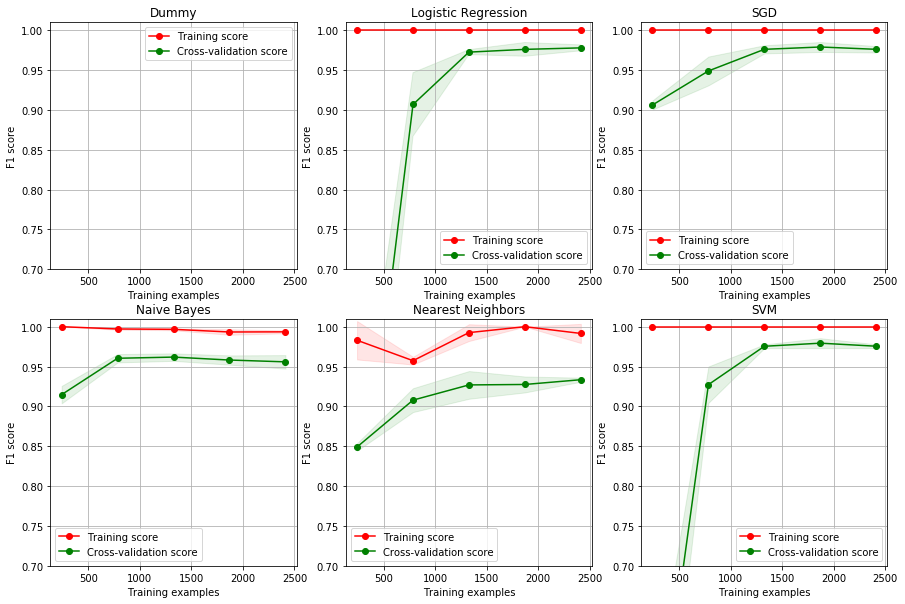

In [62]:
plot_learning_curves()

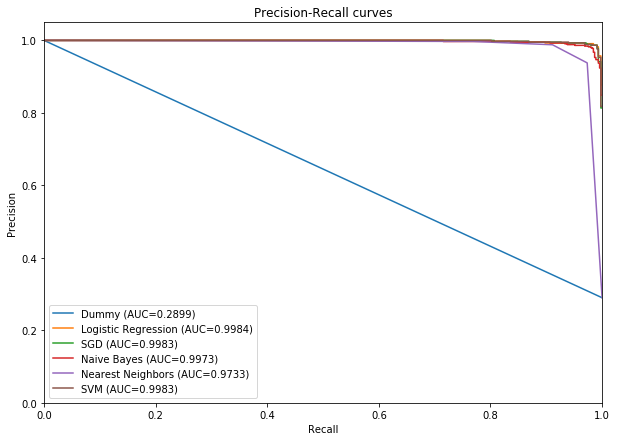

In [63]:
plot_precision_recall()

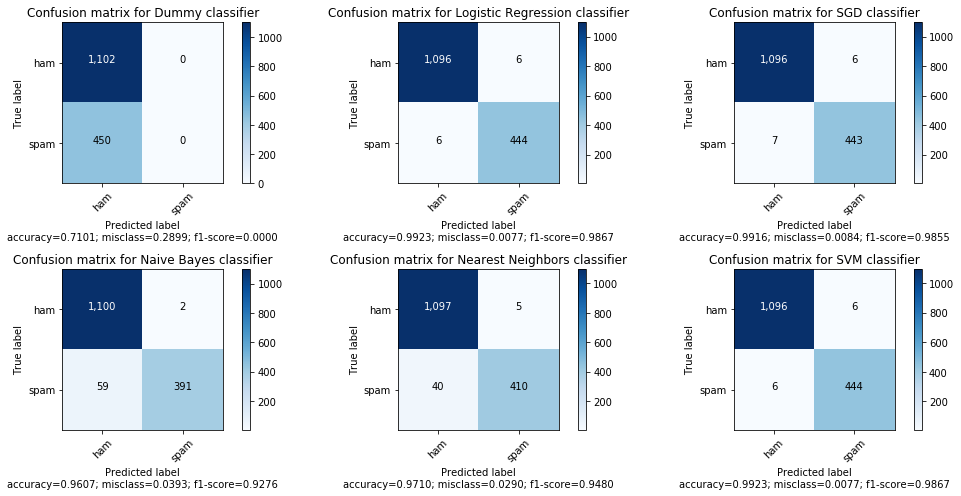

In [64]:
plot_confusion()

# REPRESENTATION 2 - Centroids of Word Embeddings

## 2.1 MEAN EMBEDDINGS

In [68]:
def download_file_from_google_drive(id, destination):
    URL = "https://drive.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [69]:
def download_embeddings():
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        print('File "GoogleNews-vectors-negative300.bin" already exists!')
        return
    file_id = '0B7XkCwpI5KDYNlNUTTlSS21pQmM'
    destination = 'GoogleNews-vectors-negative300.bin.gz'
    print('Downloading "Google News" pre-trained word vectors...')
    #download_file_from_google_drive(file_id, destination)
    print('Word vectors file downloaded.')
    print('Extracting...')
    with gzip.open('GoogleNews-vectors-negative300.bin.gz', 'r') as f_in, open('GoogleNews-vectors-negative300.bin', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
    print('File extracted.')

In [70]:
download_embeddings()

File "GoogleNews-vectors-negative300.bin" already exists!


### Feature extraction - Data representation

In [71]:
from gensim.models.keyedvectors import KeyedVectors

def load_embeddings(fname, vocab):
    model = KeyedVectors.load_word2vec_format(fname, binary=True)
    dim = model.vectors.shape[1]
    embeddings = np.zeros((len(vocab), dim))

    for word in vocab:
        if word in model:
            embeddings[vocab[word]] = model[word]
        else:
            embeddings[vocab[word]] = np.random.uniform(-0.25, 0.25, dim)
    return embeddings

c:\program files\python36\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [72]:
def EmbeddingMeanVectorizer(docs, model):
    dim = model.shape[1]
    mailvec = np.zeros((len(docs), dim))
    for i, doc in enumerate(docs):
        sent_vec = np.zeros(dim)
        numw = 0
        for w in doc.split():
            try:
                sent_vec = np.add(sent_vec, model[vectorizer.vocabulary_[w]])
                numw += 1
            except:
                pass
        mailvec[i] = sent_vec/numw
    return mailvec

In [73]:
X_train, X_test, y_train, y_test = train_test_split(processed_emails, y, test_size=0.3, random_state=0, stratify=y)

In [74]:
vectorizer = TfidfVectorizer(ngram_range=(1,1),  use_idf=True)

In [75]:
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

Build embedding matrix

In [76]:
embeddings = load_embeddings('C:/Users/Stamatis/Documents/Python_scripts/project/models/GoogleNews-vectors-negative300.bin', vectorizer.vocabulary_)

In [77]:
X_train = EmbeddingMeanVectorizer(X_train, embeddings)

In [78]:
X_test = EmbeddingMeanVectorizer(X_test, embeddings)

In [79]:
X_train.shape

(3620, 300)

### Hyperparameter tuning - Fitting

In [80]:
#Estimators
dummy = DummyClassifier(strategy='most_frequent', random_state=13)
logregr = LogisticRegression(solver='liblinear', random_state=13)
sgd = SGDClassifier(max_iter=1000, tol=1e-3, random_state=13, n_jobs=-1)
gnb = GaussianNB()
knn = KNeighborsClassifier(n_jobs=-1)
svm = LinearSVC(max_iter=100000, random_state=13)

#Cross validation strategy
skf = StratifiedKFold(n_splits=10, random_state=1)
#Scores could also be ['precision', 'recall', 'f1', 'accuracy']
scores = ['f1']

In [81]:
params = [{'C': [0.001, 0.01, 0.1, 1, 10, 100]}]
logregr = hyper_tuning(X_train, X_test, scores, logregr, params, skf)

# Estimator: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=13, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)
# Tuning hyper-parameters for f1
Best parameters set found on development set:
{'C': 10}

Grid scores on development set:
0.000 (+/-0.000) for {'C': 0.001}
0.006 (+/-0.017) for {'C': 0.01}
0.788 (+/-0.053) for {'C': 0.1}
0.913 (+/-0.025) for {'C': 1}
0.939 (+/-0.031) for {'C': 10}
0.939 (+/-0.035) for {'C': 100}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           0     0.9599    0.9773    0.9685      1102
           1     0.9419    0.9000    0.9205       450

   micro avg     0.9549    0.9549    0.9549      1552
   macro avg     0.9509    0.9387    0.9445      1552

In [82]:
params = [{'alpha': [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10]}]
sgd = hyper_tuning(X_train, X_test, scores, sgd, params, skf)

# Estimator: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=13, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)
# Tuning hyper-parameters for f1
Best parameters set found on development set:
{'alpha': 0.0001}

Grid scores on development set:
0.928 (+/-0.042) for {'alpha': 1e-07}
0.921 (+/-0.050) for {'alpha': 1e-06}
0.926 (+/-0.029) for {'alpha': 1e-05}
0.932 (+/-0.044) for {'alpha': 0.0001}
0.923 (+/-0.038) for {'alpha': 0.001}
0.804 (+/-0.043) for {'alpha': 0.01}
0.000 (+/-0.000) for {'alpha': 0.1}
0.000 (+/-0.000) for {'alpha': 1.0}
0.000 (+/-0.000) for {'alpha': 10}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evalu

In [83]:
params = {'var_smoothing': [1e-02, 1e-04, 1e-09]}
nb = hyper_tuning(X_train, X_test, scores, gnb, params, skf)

# Estimator: GaussianNB(priors=None, var_smoothing=1e-09)
# Tuning hyper-parameters for f1
Best parameters set found on development set:
{'var_smoothing': 0.0001}

Grid scores on development set:
0.797 (+/-0.063) for {'var_smoothing': 0.01}
0.798 (+/-0.062) for {'var_smoothing': 0.0001}
0.798 (+/-0.062) for {'var_smoothing': 1e-09}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           0     0.9598    0.8439    0.8981      1102
           1     0.7050    0.9133    0.7957       450

   micro avg     0.8640    0.8640    0.8640      1552
   macro avg     0.8324    0.8786    0.8469      1552
weighted avg     0.8859    0.8640    0.8684      1552

Accuracy: 0.8640   f1-score(for the positive class): 0.7957


In [84]:
params = [{'n_neighbors': np.arange(1, 4), 'leaf_size': [20, 30], 'weights': ['distance', 'uniform']}]
knn = hyper_tuning(X_train, X_test, scores, knn, params, skf)

# Estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')
# Tuning hyper-parameters for f1
Best parameters set found on development set:
{'leaf_size': 20, 'n_neighbors': 1, 'weights': 'distance'}

Grid scores on development set:
0.926 (+/-0.033) for {'leaf_size': 20, 'n_neighbors': 1, 'weights': 'distance'}
0.926 (+/-0.033) for {'leaf_size': 20, 'n_neighbors': 1, 'weights': 'uniform'}
0.926 (+/-0.033) for {'leaf_size': 20, 'n_neighbors': 2, 'weights': 'distance'}
0.902 (+/-0.043) for {'leaf_size': 20, 'n_neighbors': 2, 'weights': 'uniform'}
0.919 (+/-0.045) for {'leaf_size': 20, 'n_neighbors': 3, 'weights': 'distance'}
0.917 (+/-0.045) for {'leaf_size': 20, 'n_neighbors': 3, 'weights': 'uniform'}
0.926 (+/-0.033) for {'leaf_size': 30, 'n_neighbors': 1, 'weights': 'distance'}
0.926 (+/-0.033) for {'leaf_size': 30, 'n_neighbors': 1, 'weights': 'uniform'}
0.926 (+/-0.033

In [85]:
params = [{'C': [0.0001, 0.001, .01, 1, 10, 100, 1000]}]
svm = hyper_tuning(X_train, X_test, scores, svm, params, skf)

# Estimator: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=100000,
     multi_class='ovr', penalty='l2', random_state=13, tol=0.0001,
     verbose=0)
# Tuning hyper-parameters for f1
Best parameters set found on development set:
{'C': 1}

Grid scores on development set:
0.000 (+/-0.000) for {'C': 0.0001}
0.000 (+/-0.000) for {'C': 0.001}
0.802 (+/-0.034) for {'C': 0.01}
0.939 (+/-0.043) for {'C': 1}
0.938 (+/-0.039) for {'C': 10}
0.921 (+/-0.039) for {'C': 100}
0.916 (+/-0.051) for {'C': 1000}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           0     0.9616    0.9764    0.9689      1102
           1     0.9400    0.9044    0.9219       450

   micro avg     0.9555    0.9555    0.9555      1552
   macro avg     0.9508    0.9404    0.9454      1552
weighted avg    

In [86]:
dummy.fit(X_train, y_train)
names = ['Dummy', 'Logistic Regression', 'SGD', 'Naive Bayes', 'Nearest Neighbors', 'SVM']
classifiers = [dummy, logregr, sgd, nb, knn, svm]

### Evaluation

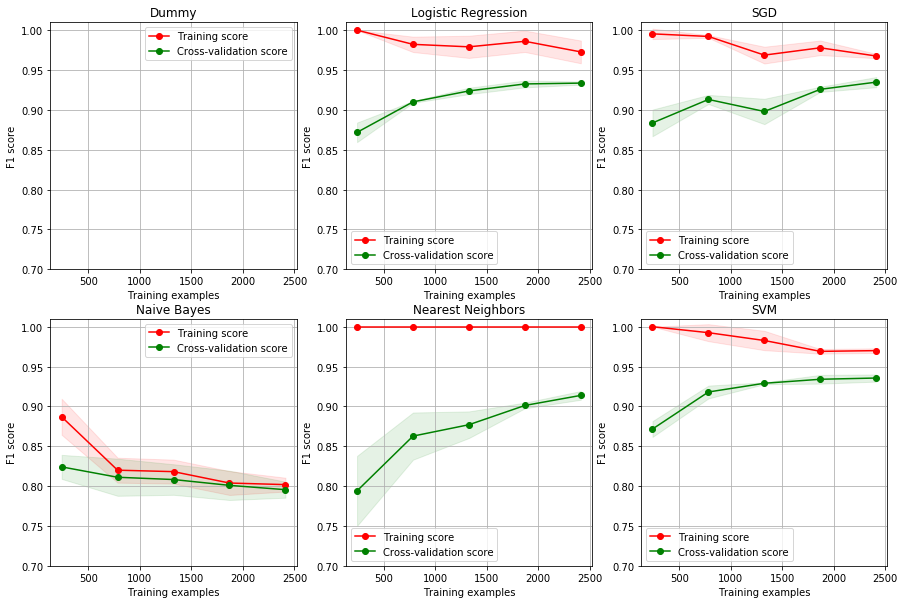

In [87]:
plot_learning_curves()

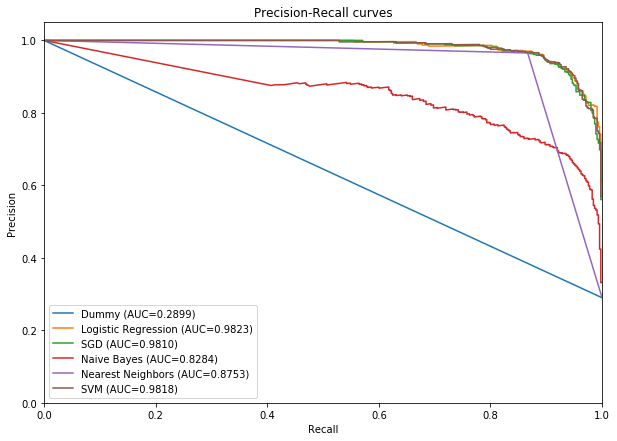

In [88]:
plot_precision_recall()

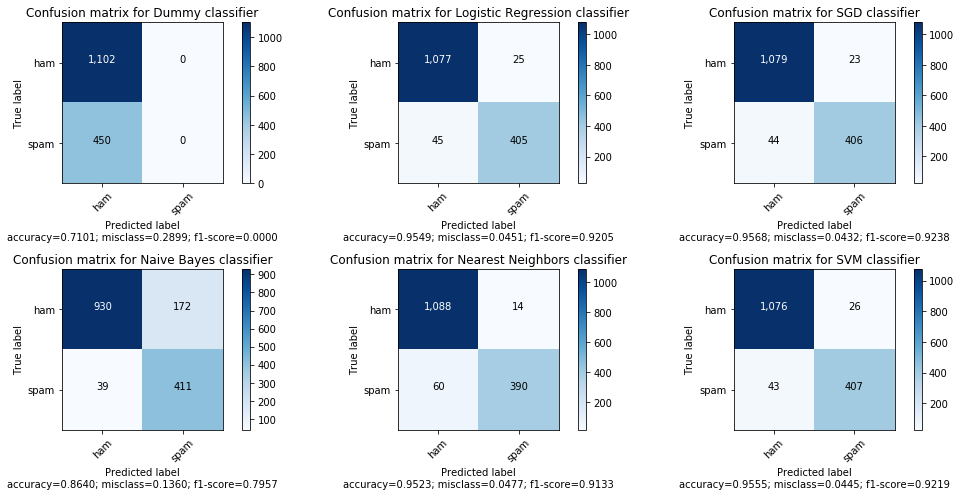

In [89]:
plot_confusion()

## 2.2 TFIDF WEIGHTED EMBEDDINGS

In [90]:
def EmbeddingTfidfVectorizer(docs, model, tfidf):
    dim = model.shape[1]
    mailvec = np.zeros((len(docs), dim))
    for i, doc in enumerate(docs):
        sent_vec = np.zeros(dim)
        numw = 0
        for w in doc.split():
            try:
                tfidf_score = tfidf[i, tfidf_feat.index(w)]
                sent_vec = np.add(sent_vec, model[vectorizer.vocabulary_[w]]*tfidf_score)
            except:
                pass
        mailvec[i] = sent_vec
    return mailvec

### Feature extraction - Data representation

In [113]:
X_train, X_test, y_train, y_test = train_test_split(processed_emails, y, test_size=0.3, random_state=0, stratify=y)

In [114]:
vectorizer = TfidfVectorizer(ngram_range=(1,1),  use_idf=True)

In [115]:
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

See sorted vocabulary terms with their index

In [116]:
sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1))[:10]

[('aa', 0),
 ('aaa', 1),
 ('aaas', 2),
 ('aabda', 3),
 ('aabvmmq', 4),
 ('aaer', 5),
 ('aafco', 6),
 ('aaiabe', 7),
 ('aaigrcrb', 8),
 ('aaihmqv', 9)]

In [117]:
tfidf_feat = vectorizer.get_feature_names()

An example: find tfidf score of word 'subject'

In [118]:
X_train_tfidf [0, tfidf_feat.index('subject')]

0.04142793577635406

Print shapes of tfidf matrix and embeddings matrix

In [119]:
print(X_train_tfidf.shape)
print(embeddings.shape)

(3620, 36738)
(36738, 300)


In [120]:
#X_train = EmbeddingTfidfVectorizer(X_train, embeddings, X_train_tfidf)

In [121]:
#X_test = EmbeddingTfidfVectorizer(X_test, embeddings, X_test_tfidf)

In [122]:
#X_train.shape

Instead of using our function EmbeddingTfidfVectorizer() another aproach is to use the dot product of tfidf and embedding matrices:

In [123]:
X_train = np.dot(X_train_tfidf.todense(), embeddings)

In [124]:
X_test = np.dot(X_test_tfidf.todense(), embeddings)

### Hyperparameter tuning - Fitting

In [125]:
#Estimators
dummy = DummyClassifier(strategy='most_frequent', random_state=13)
logregr = LogisticRegression(max_iter=1000, solver='liblinear', random_state=13)
sgd = SGDClassifier(max_iter=1000, tol=1e-3, random_state=13, n_jobs=-1)
gnb = GaussianNB()
knn = KNeighborsClassifier(n_jobs=-1)
svm = LinearSVC(max_iter=1000000, random_state=13)

#Cross validation strategy
skf = StratifiedKFold(n_splits=10, random_state=1)
#Scores could also be ['precision', 'recall', 'f1']
scores = ['f1']
names = ['Dummy', 'Logistic Regression', 'SGD', 'Gaussian NB', 'Nearest Neighbors', 'SVM']

In [126]:
params = [{'C': [0.001, 0.01, 0.1, 1, 10, 100]}]
logregr = hyper_tuning(X_train, X_test, scores, logregr, params, skf)

# Estimator: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=13, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)
# Tuning hyper-parameters for f1
Best parameters set found on development set:
{'C': 1}

Grid scores on development set:
0.562 (+/-0.098) for {'C': 0.001}
0.840 (+/-0.041) for {'C': 0.01}
0.909 (+/-0.032) for {'C': 0.1}
0.912 (+/-0.040) for {'C': 1}
0.905 (+/-0.028) for {'C': 10}
0.887 (+/-0.047) for {'C': 100}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           0     0.9599    0.9773    0.9685      1102
           1     0.9419    0.9000    0.9205       450

   micro avg     0.9549    0.9549    0.9549      1552
   macro avg     0.9509    0.9387    0.9445      1552

In [127]:
params = [{'alpha': [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10]}]
sgd = hyper_tuning(X_train, X_test, scores, sgd, params, skf)

# Estimator: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=13, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)
# Tuning hyper-parameters for f1
Best parameters set found on development set:
{'alpha': 0.01}

Grid scores on development set:
0.894 (+/-0.041) for {'alpha': 1e-07}
0.889 (+/-0.060) for {'alpha': 1e-06}
0.894 (+/-0.036) for {'alpha': 1e-05}
0.887 (+/-0.058) for {'alpha': 0.0001}
0.908 (+/-0.044) for {'alpha': 0.001}
0.909 (+/-0.037) for {'alpha': 0.01}
0.808 (+/-0.040) for {'alpha': 0.1}
0.150 (+/-0.091) for {'alpha': 1.0}
0.000 (+/-0.000) for {'alpha': 10}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluat

In [128]:
params = {'var_smoothing': [1e-02, 1e-04, 1e-09]}
nb = hyper_tuning(X_train, X_test, scores, gnb, params, skf)

# Estimator: GaussianNB(priors=None, var_smoothing=1e-09)
# Tuning hyper-parameters for f1
Best parameters set found on development set:
{'var_smoothing': 0.0001}

Grid scores on development set:
0.608 (+/-0.063) for {'var_smoothing': 0.01}
0.616 (+/-0.074) for {'var_smoothing': 0.0001}
0.616 (+/-0.074) for {'var_smoothing': 1e-09}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           0     0.8388    0.9111    0.8734      1102
           1     0.7239    0.5711    0.6385       450

   micro avg     0.8125    0.8125    0.8125      1552
   macro avg     0.7814    0.7411    0.7560      1552
weighted avg     0.8055    0.8125    0.8053      1552

Accuracy: 0.8125   f1-score(for the positive class): 0.6385


In [129]:
params = [{'n_neighbors': np.arange(1, 4), 'leaf_size': [20, 30], 'weights': ['distance', 'uniform']}]
knn = hyper_tuning(X_train, X_test, scores, knn, params, skf)

# Estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')
# Tuning hyper-parameters for f1
Best parameters set found on development set:
{'leaf_size': 20, 'n_neighbors': 1, 'weights': 'distance'}

Grid scores on development set:
0.922 (+/-0.026) for {'leaf_size': 20, 'n_neighbors': 1, 'weights': 'distance'}
0.922 (+/-0.026) for {'leaf_size': 20, 'n_neighbors': 1, 'weights': 'uniform'}
0.922 (+/-0.026) for {'leaf_size': 20, 'n_neighbors': 2, 'weights': 'distance'}
0.889 (+/-0.044) for {'leaf_size': 20, 'n_neighbors': 2, 'weights': 'uniform'}
0.912 (+/-0.033) for {'leaf_size': 20, 'n_neighbors': 3, 'weights': 'distance'}
0.911 (+/-0.034) for {'leaf_size': 20, 'n_neighbors': 3, 'weights': 'uniform'}
0.922 (+/-0.026) for {'leaf_size': 30, 'n_neighbors': 1, 'weights': 'distance'}
0.922 (+/-0.026) for {'leaf_size': 30, 'n_neighbors': 1, 'weights': 'uniform'}
0.922 (+/-0.026

In [130]:
params = [{'C': [0.0001, 0.001, .01, 1, 10, 100, 1000]}]
svm = hyper_tuning(X_train, X_test, scores, svm, params, skf)

# Estimator: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000000,
     multi_class='ovr', penalty='l2', random_state=13, tol=0.0001,
     verbose=0)
# Tuning hyper-parameters for f1
Best parameters set found on development set:
{'C': 0.01}

Grid scores on development set:
0.525 (+/-0.099) for {'C': 0.0001}
0.845 (+/-0.050) for {'C': 0.001}
0.913 (+/-0.035) for {'C': 0.01}
0.899 (+/-0.034) for {'C': 1}
0.883 (+/-0.050) for {'C': 10}
0.875 (+/-0.045) for {'C': 100}
0.872 (+/-0.046) for {'C': 1000}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           0     0.9523    0.9791    0.9655      1102
           1     0.9451    0.8800    0.9114       450

   micro avg     0.9504    0.9504    0.9504      1552
   macro avg     0.9487    0.9296    0.9385      1552
weighted avg

In [131]:
dummy.fit(X_train, y_train)
names = ['Dummy', 'Logistic Regression', 'SGD', 'Naive Bayes', 'Nearest Neighbors', 'SVM']
classifiers = [dummy, logregr, sgd, nb, knn, svm]

### Evaluation

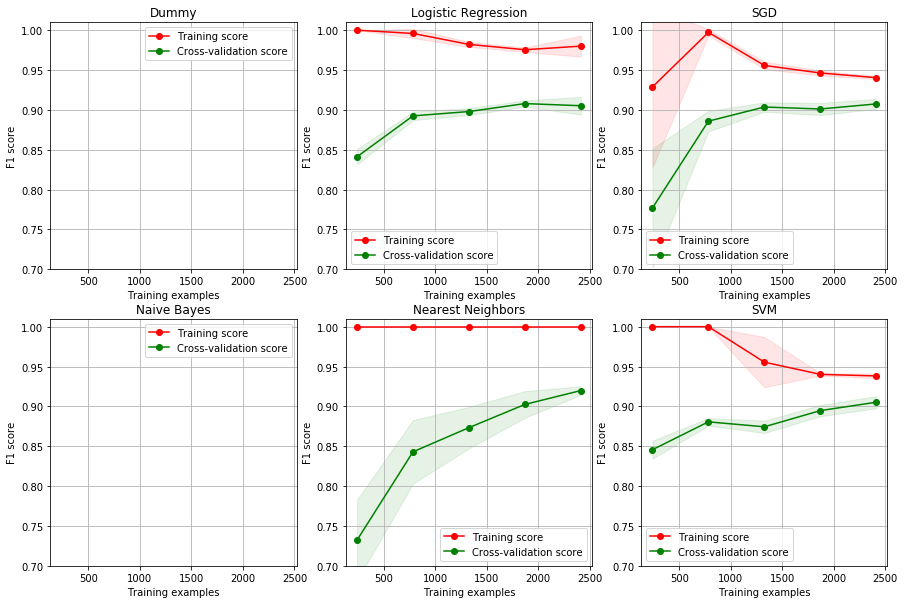

In [132]:
plot_learning_curves()

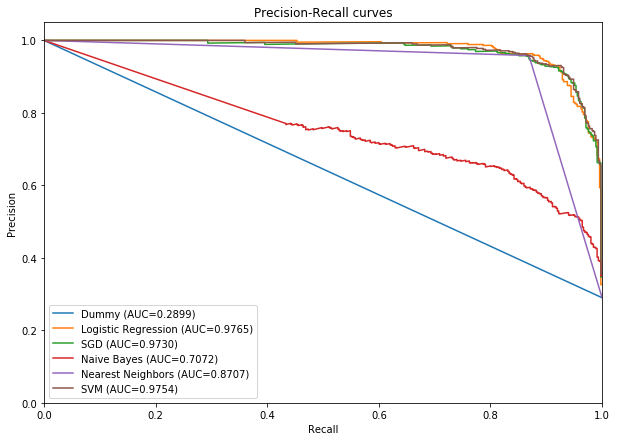

In [133]:
plot_precision_recall()

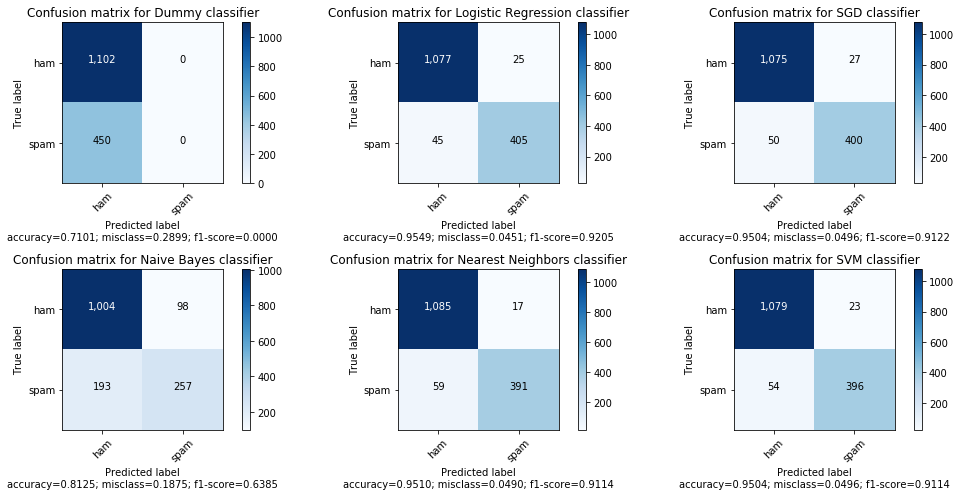

In [134]:
plot_confusion()